# Dropout and Batch Normalization

In this notebook we will implement Dropout and Batch Normalization. Batch Normalization both improves generalization and training speed. Dropout is considered to be a regularization technique.

Goal of this lab is to:

* Implement and understand basic aspects of Dropout
* Implement and understand basic aspects of Batch Normalization

References:
* "Dropout: A Simple Way to Prevent Neural Networks from Overfitting": https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

* "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift": https://arxiv.org/abs/1502.03167

# Setup

In [1]:
%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

import torch
from torch.autograd.function import InplaceFunction
from torch.autograd import Variable
from itertools import repeat
from torch import nn
from torch import optim

C:\Users\Maxim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data(which="mnist")

# Whiteboard exercises

* (1.0, only this lab) Write equations for training and inference phase of Dropout. Explain inference mode of Dropout (see https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf, p 1531)
* (0.5, only this lab) Write equations for training and inference phase of Batch Normalization
* (0.5) Using either stability, or bias-variance perspective on generalization, argue why Dropout should prevent overfitting? 
* (0.5) Can Batch Normalization prevent vanishing gradient? How?
* (1.0) Yet another perspective on generalization in Deep Networks is through the lenses of memorization, see https://arxiv.org/abs/1611.03530. Do you think Dropout prevents or encourages memorization? 

(And any left-out exercise from the previous lab)

# Dropout

Note: We use MNIST to be able to quickly and in a stable way fit data, which makes it a good target for studying generalization.

## Exercise 1: Implement and show better generalization of Dropout

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without dropout?

b) What train and test accuracy did you achieve with dropout (best alpha)?

Hint: use torch.rand()

In [3]:
import pdb
class BernoulliDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(BernoulliDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise e ~ B(alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            #forward for Dropout scenario
            #new_x = x
            #for i in range(0,x.shape[1]):
            #pdb.set_trace()
            x = Variable(torch.bernoulli(self.alpha*torch.ones(1, x[:1,:].shape[1]) ))*x
            return x
        else:
            #forward for scenario without Dropout
            return x
#x_train[:,:1].shape
#(torch.bernoulli(0.5*x_train[:,:1]))*x_train

In [88]:
answers = {"a": "Very good, result is aproximately 0.83", "b": "Result is about .87 when alpha = 0.93"}
json.dump(answers, open("8_ex1.json", "w"))

100%|████████████████████████████████████████| 100/100 [00:05<00:00, 16.78it/s]


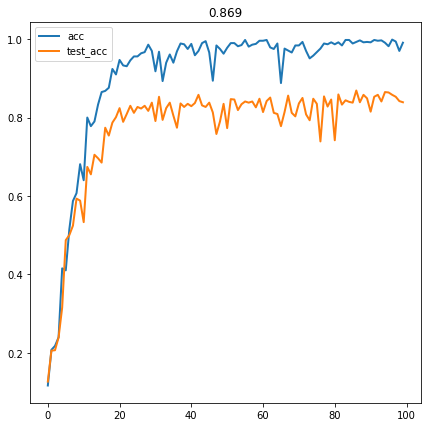

In [4]:
## Starting code

input_dim = 784
output_dim = 10
alpha = 0.93
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    model.add_module("dropout_{}".format(id), BernoulliDropout(alpha))
    model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

# Batch Normalization

## Exercise 2: Implement Batch Normalization

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without BN?

b) What train and test accuracy did you achieve with BN?

c) Can you use a larger LR in network with BN?

In [8]:
import pdb
def batch_norm(input, running_mean, running_var, weight, bias,
    training, momentum, eps):
    
    running_mean.set_(momentum * running_mean + (1 - momentum) * input.mean(0).data)
    running_var.set_(momentum * running_var + (1 - momentum) * input.var(0).data)
    
    if training:
        #pdb.set_trace()
        return (input - Variable(running_mean))/Variable(torch.sqrt(running_var))
    else:
        return input
    
class BatchNorm(nn.Module):

    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.weight = nn.Parameter(torch.Tensor(num_features))
        self.bias = nn.Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def _check_input_dim(self, input):
        return NotImplemented

    def forward(self, input):
        return batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training, self.momentum, self.eps)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)


100%|████████████████████████████████| 100/100 [00:02<00:00, 36.71it/s]


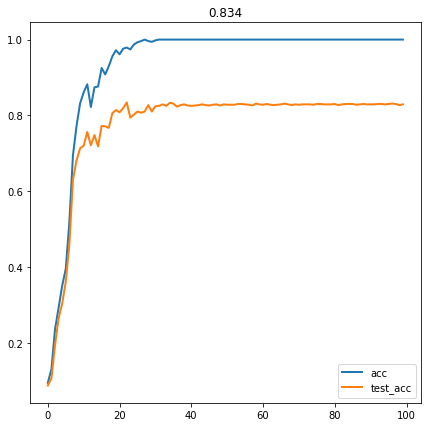

In [125]:
## Starting code

input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    bn = BatchNorm(D)
    #model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

In [5]:
answers = {"a": "without BN and with LR = 1.0 result was about 0.3", "b": "with BN and with LR = 1.0 result about 0.8", "c": "defenetly yes, with hight LR network with RN works better than network without BN and oppositely network with BN gives low result when LR is low, in same time network without BN and low LR gives hight result"}
json.dump(answers, open("8_ex2.json", "w"))

## Exercise 3: Does it really reduce internal drift?

Produce an experiment similar to Figure 1 in https://arxiv.org/pdf/1502.03167.pdf (you can use our data and neural network). 

<img width=200 src="https://github.com/gmum/nn2018/raw/master/lab/fig/8/fig1.png">

Result is just a figure, save it to 8_3.png.

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 37.57it/s]


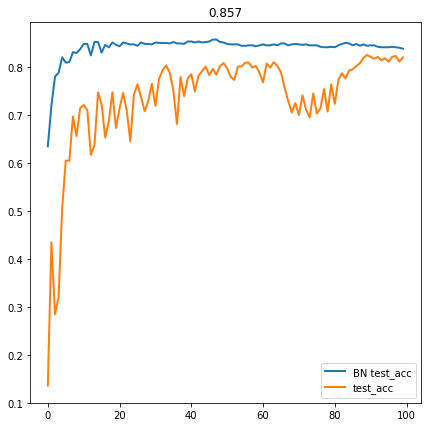

In [59]:

input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]


BN_model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    BN_model.add_module("linear_{}".format(id), lin)
    bn = BatchNorm(D)
    BN_model.add_module("bn_{}".format(id), bn)
    BN_model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
BN_model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
BN_optimizer = optim.SGD(BN_model.parameters(), lr=0.9, momentum=0.9)
BN_H = train(loss=loss, model=BN_model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=BN_optimizer, batch_size=128, n_epochs=100)



model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)


plt.title(max(max(H['test_acc']), max(BN_H['test_acc'])))
plt.plot(BN_H['test_acc'], label="BN test_acc")
plt.plot(H['test_acc'], label="test_acc")
plt.legend()

plt.savefig("8_ex31.png")

In [11]:
plt.savefig("8_ex3.png")

No handles with labels found to put in legend.


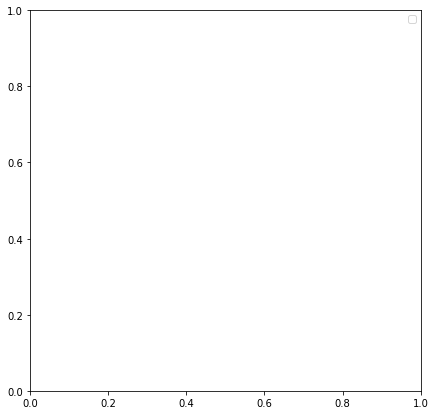

In [12]:
plt.legend()